# PySindy

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error

# Ignore integration and solver convergence warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
import pysindy as ps
from tqdm import tqdm
from support_functions import *

## Load dataset

It generates the database concernig the evolution over time of Snowshoe Hare and Canadian lynx 

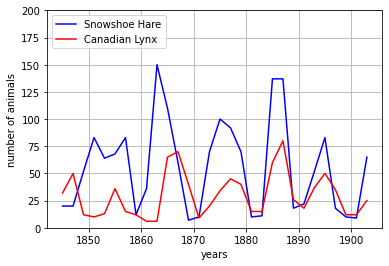

In [41]:
X,t,dt = generate_populations_dataset()
t = np.arange(0,60,dt)

X = X[0:20,:]
t = t[0:20]

380


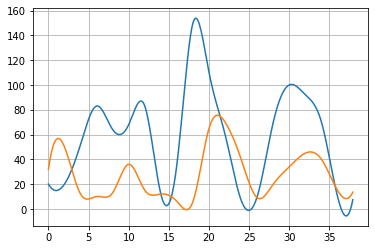

In [42]:

dt_new = 0.1
t_new = np.arange(t[0],t[-1],dt_new)
X_new = interpolation(t ,X, t_new)
print(len(t_new))
t = t_new
X = X_new
dt = dt_new

plt.figure()
plt.plot(t,X[:,0])
plt.plot(t,X[:,1])
plt.grid()


<br>
<br>
<br>
<br>
<br>
<br>

## Fit Sindy Model 



In [74]:
# SINDY model parameters
feature_names = ['x', 'y']
threshold = 1e-20
alpha = 0
n_models = 500
subset_size = X.shape[0] - int(X.shape[0] * 0.10)
max_iter = 1000
#subset_size = X.shape[0]# - int(X.shape[0] * 0.10)

#ensemble_optimizer = ps.STLSQ(threshold = threshold, alpha = alpha )
ensemble_optimizer = ps.SR3(threshold = threshold ,max_iter= max_iter)
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer, feature_library=ps.PolynomialLibrary(6,library_ensemble=True))
model.fit(X, t=dt, ensemble=True, n_models=n_models, n_subset=subset_size, quiet=False, n_candidates_to_drop=4)

model.print()

ensemble_coefs = np.asarray(model.coef_list)
mean_ensemble_coefs = np.mean(ensemble_coefs, axis=0)
median_ensemble_coefs = np.median(ensemble_coefs, axis=0)

(x)' = 11.167 1 + 1.702 x + -0.181 y + -1.767 x^2 + -0.269 x y + -0.001 y^2 + 0.037 x^3 + 0.078 x^2 y + 0.018 x y^2 + -0.001 x^3 y + -0.001 x^2 y^2 + -0.001 x y^3
(y)' = -2.704 1 + 5.197 x + 0.035 y + 0.448 x^2 + -0.931 x y + 0.001 y^2 + -0.013 x^3 + -0.013 x^2 y + 0.053 x y^2 + -0.001 x y^3


In [75]:
# set initial conditons
x0_test = X[0,:]

# set integrator: solve_ivp , odeint
integrator = 'solve_ivp'

# set integration  parameters
integrator_kws = {}

# Only for solve_ivp
# RK45 , RK23 , DOP853 , Radau , BDF , LSODA
if integrator == 'solve_ivp':
    integrator_kws['method'] = 'Radau'
    #integrator_kws['max_step'] = 1e20
    #integrator_kws['min_step'] = 1e15
else:
    print()
    #mxstep = 1e20
    #integrator_kws['hmax'] = 10
    #integrator_kws['hmin'] = 10
    
integrator_kws['rtol'] = 1e-8
integrator_kws['atol'] = 1e-8

dt_test = 1e-3
t_test = np.arange(0,36,dt_test)

# function to zero out any short-term unstable models 
def integration_metric(coef_list, optimizer):
    #t_test = t
    stable_list = np.zeros((np.shape(coef_list)[0]),dtype='int')
    print(stable_list.shape)
    kk = 0

    for k in range(1):
        for i in tqdm(range(np.shape(coef_list)[0])):
            optimizer.coef_ = coef_list[i, :, :]
            x_test_sim = model.simulate(x0_test, t_test, integrator=integrator ,integrator_kws = integrator_kws)
            
            var_1 = np.var(x_test_sim[int(0.33*len(x_test_sim[:,0])):-1,0])
            var_2 = np.var(x_test_sim[int(0.33*len(x_test_sim[:,0])):-1,0])

            if ((var_1 < 200) or (var_2 < 200)):
                coef_list[i, :, :] = 0.0
            elif np.any(np.abs(x_test_sim) > 200):
                coef_list[i, :, :] = 0.0
            elif(np.any((x_test_sim) < 0)):
                coef_list[i, :, :] = 0.0
            else:
                stable_list[kk] = i
                kk = kk+1
        
    print(kk)
    stable_list = stable_list[0:kk]
    stable_list = stable_list.tolist()
    return coef_list , stable_list


stable_ensemble_coefs , stable_list = integration_metric(np.asarray(ensemble_coefs), ensemble_optimizer)

(500,)


100%|██████████| 500/500 [26:32<00:00,  3.19s/it] 

11


In [76]:
stable_ensemble_coefs_1 = stable_ensemble_coefs[stable_list]
#stable_ensemble_coefs_1 = ensemble_coefs
mean_ensemble_coefs = np.mean(stable_ensemble_coefs_1, axis=0)
median_ensemble_coefs = np.median(stable_ensemble_coefs_1, axis=0)


In [77]:
x_test_sims, x_test_sim_mean, top_line, bottom_line = simulate_model( x_0 = x0_test, 
                                                                    t_test = t_test,
                                                                    model = model, 
                                                                    ensemble_coefs = stable_ensemble_coefs_1, 
                                                                    ensemble_optimizer = ensemble_optimizer, 
                                                                    integrator_kws  = integrator_kws, 
                                                                    integrator = integrator)


100%|██████████| 11/11 [00:32<00:00,  2.97s/it]


<br>
<br>
<br>
<br>
<br>
<br>

## Plot the results

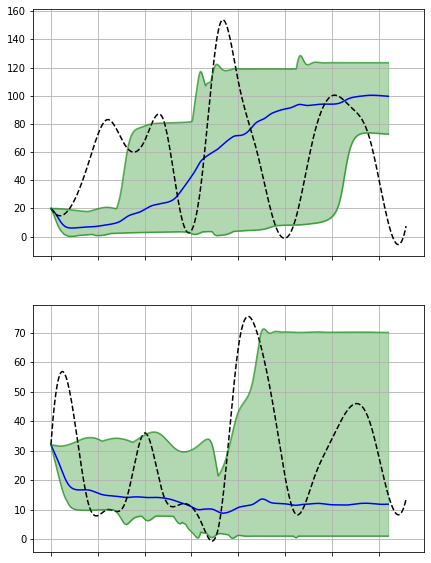

In [78]:
plot_functions(t_test, x_test_sim_mean, t, X,  top_line, bottom_line , feature_names)

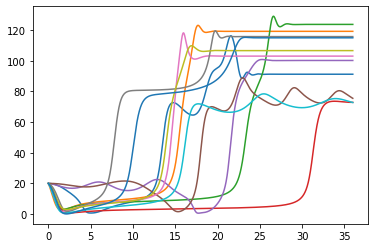

In [79]:
plt.figure()
for ii in range(x_test_sims.shape[0]):
    plt.plot(t_test, x_test_sims[ii,:,0])

2658.691353323681


36000

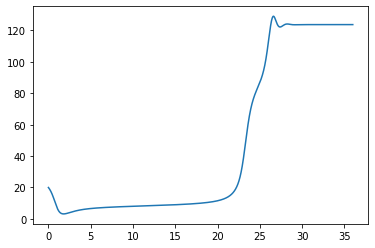

In [80]:
ii = 2
plt.plot(t_test, x_test_sims[ii,:,0])
varianza = np.var(x_test_sims[ii,int(0.33*len(x_test_sims[:,0])):-1,0])
print(varianza)

len(x_test_sims[ii,:,0])

In [81]:
x0_test = x_0 = X[0,:]
ensemble_optimizer.coef_ = mean_ensemble_coefs
x_test_sim_meam_coeff = model.simulate(x0_test, t_test, integrator=integrator,integrator_kws = integrator_kws)

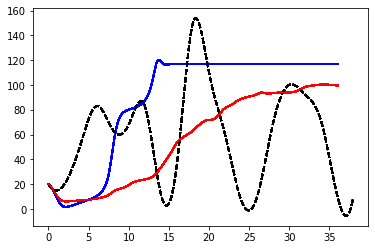

In [82]:
plt.figure()
for ii in range(100):
    plt.plot(t_test, x_test_sim_meam_coeff[:,0],'b')
    plt.plot(t, X[:,0],'--k')
    plt.plot(t_test, x_test_sim_mean[:,0],'r')